In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import warnings
import copy
#GPU configuration
warnings.filterwarnings('ignore')
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Hyperparameters
IMG_WIDTH=100
IMG_HEIGHT=100
BATCH_SIZE=32
EPOCHS=150
LEARNING_RATE=0.001
#L2 regularization
WEIGHT_DECAY=1e-5
#Regularization to prevent overconfidence   
LABEL_SMOOTHING=0.1
#Epochs to wait for improvement before stopping
EARLY_STOPPING_PATIENCE=10

In [2]:
#data loading and augmentation
data_transforms={
    'train':transforms.Compose([
        transforms.RandomResizedCrop((IMG_WIDTH,IMG_HEIGHT)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'validation':transforms.Compose([
        transforms.Resize((IMG_WIDTH,IMG_HEIGHT)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize((IMG_WIDTH,IMG_HEIGHT)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}
data_dir='dataset'
folders=['train','validation','test']
image_datasets={
    x:datasets.ImageFolder(
        os.path.join(data_dir,x),data_transforms[x]
    )
    for x in folders
}
dataloaders={
    x:DataLoader(
        image_datasets[x],batch_size=BATCH_SIZE,shuffle=True,num_workers=4
    )
    for x in folders
}
dataset_sizes={
    x:len(image_datasets[x])
    for x in folders
}
class_names=image_datasets['train'].classes
num_classes=len(class_names)

In [ ]:
#Model definition & architecture 
class ComplexNet(nn.Module):
    def __init__(self,num_classes):
        super(ComplexNet,self).__init__()
        def cbr_block(in_f,out_f,kernel,stride=1):
            padding_val=(kernel-1)//2
            return nn.Sequential(
                nn.Conv2d(in_f,out_f,kernel_size=kernel,stride=stride,padding=padding_val),
                nn.BatchNorm2d(out_f),
                nn.ReLU(inplace=True)
            )
        #Feature extractor layers
        self.conv1=cbr_block(3,16,3)
        self.conv2=cbr_block(16,16,5,2)
        #Inception block 1
        self.inc1_3=cbr_block(16,16,3)
        self.inc1_5=cbr_block(16,16,5)
        self.inc1_7=cbr_block(16,16,7)
        self.inc1_11=cbr_block(16,16,11)
        self.bn_cat1=nn.BatchNorm2d(16+16*4)
        self.pool1=nn.MaxPool2d(2,2)
        #Inception block 2
        self.inc2_3=cbr_block(self.bn_cat1.num_features,32,3,2)
        self.inc2_5=cbr_block(self.bn_cat1.num_features,32,5,2)
        self.inc2_7=cbr_block(self.bn_cat1.num_features,32,7,2)
        self.inc2_11=cbr_block(self.bn_cat1.num_features,32,11,2)
        self.bn_cat2=nn.BatchNorm2d(32*4)
        self.pool2=nn.MaxPool2d(2,2)
        #Inception block 3
        self.inc3_3=cbr_block(self.bn_cat2.num_features,32,3)
        self.inc3_5=cbr_block(self.bn_cat2.num_features,32,5)
        self.inc3_7=cbr_block(self.bn_cat2.num_features,32,7)
        self.inc3_11=cbr_block(self.bn_cat2.num_features,32,11)
        self.bn_cat3=nn.BatchNorm2d(self.bn_cat2.num_features+32*4)
        self.pool3=nn.MaxPool2d(2,2)
        #Inception block 4
        self.inc4_3=cbr_block(self.bn_cat3.num_features,64,3,2)
        self.inc4_5=cbr_block(self.bn_cat3.num_features,64,5,2)
        self.inc4_7=cbr_block(self.bn_cat3.num_features,64,7,2)
        self.inc4_11=cbr_block(self.bn_cat3.num_features,64,11,2)
        self.skip_conv=cbr_block(self.bn_cat1.num_features,64,7,4)
        self.bn_cat4=nn.BatchNorm2d(64*4+64)
        #Classifier
        self.avg_pool=nn.AdaptiveAvgPool2d((1,1))
        self.flatten=nn.Flatten()
        self.classifier=nn.Sequential(
            nn.Linear(self.bn_cat4.num_features,300),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(300,200),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(200,num_classes)
        )
    #Flow
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        #Inception block 1
        x1_3=self.inc1_3(x)
        x1_5=self.inc1_5(x)
        x1_7=self.inc1_7(x)
        x1_11=self.inc1_11(x)
        cat1=torch.cat([x,x1_3,x1_5,x1_7,x1_11],dim=1)
        bn_cat1=self.bn_cat1(cat1)
        pool1=self.pool1(bn_cat1)
        #Inception block 2
        x2_3=self.inc2_3(pool1)
        x2_5=self.inc2_5(pool1)
        x2_7=self.inc2_7(pool1)
        x2_11=self.inc2_11(pool1)
        cat2=torch.cat([x2_3,x2_5,x2_7,x2_11],dim=1)
        bn_cat2=self.bn_cat2(cat2)
        pool2=self.pool2(bn_cat2)
        #Inception block 3
        x3_3=self.inc3_3(pool2)
        x3_5=self.inc3_5(pool2)
        x3_7=self.inc3_7(pool2)
        x3_11=self.inc3_11(pool2)
        cat3=torch.cat([pool2,x3_3,x3_5,x3_7,x3_11],dim=1)
        bn_cat3=self.bn_cat3(cat3)
        pool3=self.pool3(bn_cat3)
        #Inception block 4
        x4_3=self.inc4_3(pool3)
        x4_5=self.inc4_5(pool3)
        x4_7=self.inc4_7(pool3)
        x4_11=self.inc4_11(pool3)
        skip_out=self.skip_conv(bn_cat1)
        target_h,target_w=x4_3.shape[2],x4_3.shape[3]
        skip_out_resized=nn.functional.interpolate(skip_out,size=(target_h,target_w),mode='bilinear',align_corners=False)
        cat4=torch.cat([x4_3,x4_5,x4_7,x4_11,skip_out_resized],dim=1)
        bn_cat4=self.bn_cat4(cat4)
        #Classifier
        out=self.avg_pool(bn_cat4)
        out=self.flatten(out)
        out=self.classifier(out)
        return out

In [ ]:
#Instantiate model and set up training tools
model=ComplexNet(num_classes=num_classes)
model.to(device)
#Loss function with label smoothing
criterion=nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
#Optimizer with weight decay
optimizer=optim.Adam(model.parameters(),lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
#Learning rate scheduler
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',factor=0.2,patience=5)
print(f"\nTraining model on {device}")
history={'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}
best_val_loss=float('inf')
patience_counter=0
best_model_weights=None


Training model on cuda


In [12]:
#Training & validation loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}:')
    for phase in ['train','validation']:
        if phase=='train':
            model.train()
        else:
            model.eval()
        running_loss=0.0
        running_corrects=0
        for inputs,labels in dataloaders[phase]:
            inputs=inputs.to(device)
            labels=labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase=='train'):
                outputs=model(inputs)
                _,preds=torch.max(outputs,1)
                loss=criterion(outputs,labels)
                if phase=='train':
                    loss.backward()
                    optimizer.step()
            running_loss+=loss.item()*inputs.size(0)
            running_corrects+=torch.sum(preds==labels.data)
        epoch_loss=running_loss/dataset_sizes[phase]
        epoch_acc=running_corrects.double()/dataset_sizes[phase]
        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        if phase=='train':
            history['train_loss'].append(epoch_loss)
            history['train_acc'].append(epoch_acc.item())
        else:
            history['val_loss'].append(epoch_loss)
            history['val_acc'].append(epoch_acc.item())
            scheduler.step(epoch_loss)
            if epoch_loss<best_val_loss:
                best_val_loss=epoch_loss
                patience_counter=0
                best_model_weights=copy.deepcopy(model.state_dict())
                print("Validation loss improved")
            else:
                patience_counter+=1
    if patience_counter>=EARLY_STOPPING_PATIENCE:
        print(f"\n{patience_counter} epochs with no improvement")
        model.load_state_dict(best_model_weights)
        break
print('Done Training')
torch.save(model.state_dict(),'model_improved.pth')

Epoch 1/150:
Train Loss: 3.5447 Acc: 0.0739
Validation Loss: 3.0265 Acc: 0.1663
Validation loss improved
Epoch 2/150:
Train Loss: 3.1944 Acc: 0.1316
Validation Loss: 2.9288 Acc: 0.1798
Validation loss improved
Epoch 3/150:
Train Loss: 3.0911 Acc: 0.1589
Validation Loss: 2.6625 Acc: 0.2742
Validation loss improved
Epoch 4/150:
Train Loss: 2.9738 Acc: 0.1901
Validation Loss: 2.5787 Acc: 0.3034
Validation loss improved
Epoch 5/150:
Train Loss: 2.9285 Acc: 0.2047
Validation Loss: 2.4300 Acc: 0.3303
Validation loss improved
Epoch 6/150:
Train Loss: 2.8400 Acc: 0.2273
Validation Loss: 2.4508 Acc: 0.3258
Epoch 7/150:
Train Loss: 2.7715 Acc: 0.2523
Validation Loss: 2.4079 Acc: 0.3865
Validation loss improved
Epoch 8/150:
Train Loss: 2.7626 Acc: 0.2491
Validation Loss: 2.2688 Acc: 0.3798
Validation loss improved
Epoch 9/150:
Train Loss: 2.6982 Acc: 0.2753
Validation Loss: 2.2338 Acc: 0.4360
Validation loss improved
Epoch 10/150:
Train Loss: 2.7147 Acc: 0.2870
Validation Loss: 2.2129 Acc: 0.4045

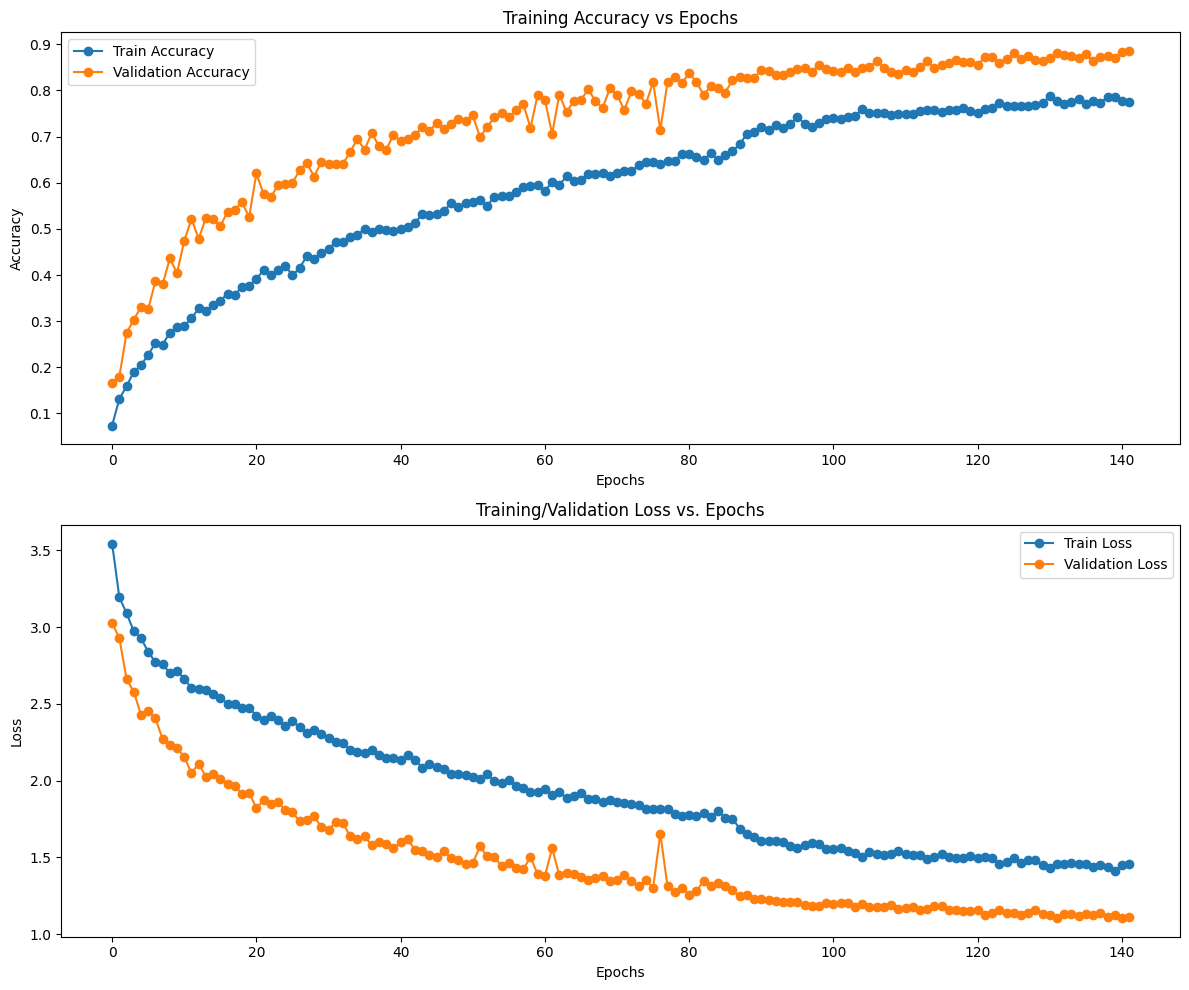


Evaluating on test data

Classification Report:

                  precision    recall  f1-score   support

           apple       1.00      0.60      0.75        10
          banana       1.00      0.90      0.95        10
        beetroot       1.00      1.00      1.00        10
         cabbage       1.00      1.00      1.00        10
        capsicum       1.00      1.00      1.00        10
          carrot       0.91      1.00      0.95        10
     cauliflower       0.91      1.00      0.95        10
   chilli pepper       0.67      1.00      0.80        10
        cinnamon       0.83      0.50      0.62        10
          cloves       0.89      0.80      0.84        10
            corn       1.00      1.00      1.00        10
      corriander       0.78      0.70      0.74        10
corriander_seeds       0.64      0.90      0.75        10
        cucumber       1.00      0.90      0.95        10
           cumin       0.83      1.00      0.91        10
        eggplant     

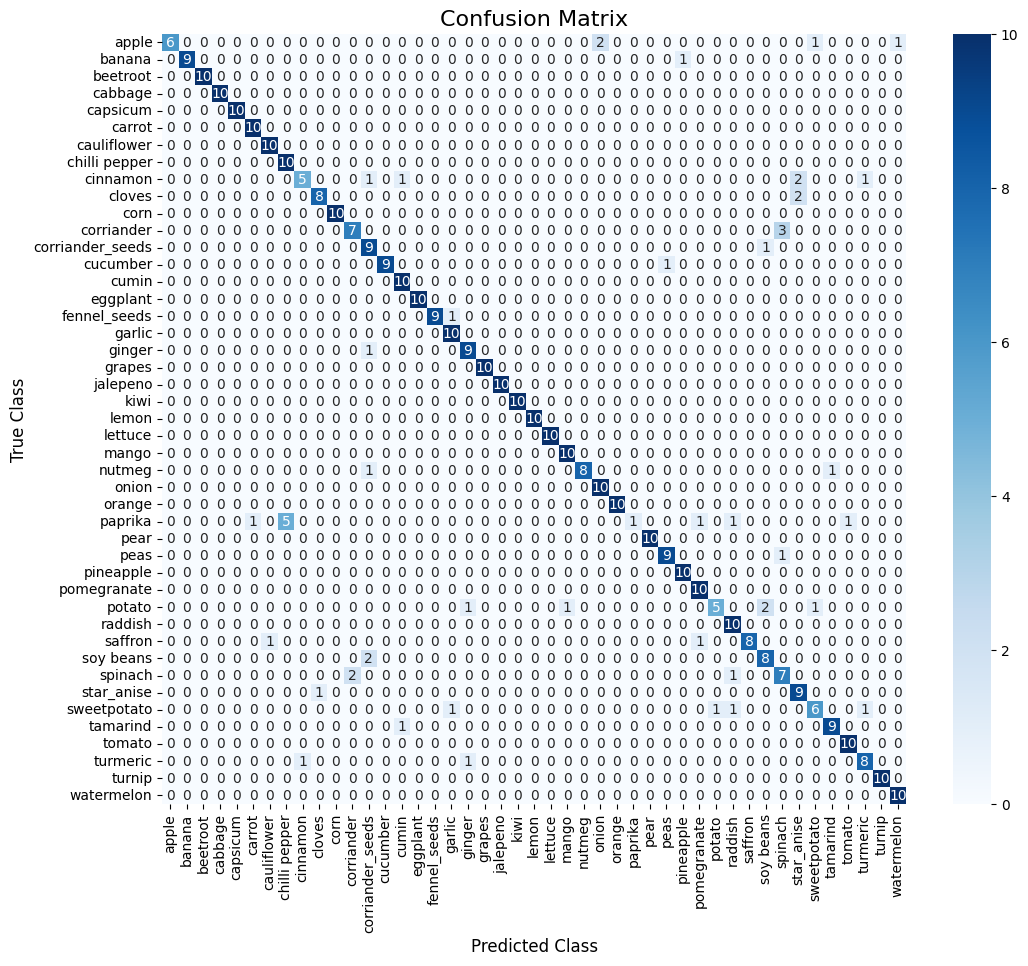


Visualizing a batch of test predictions


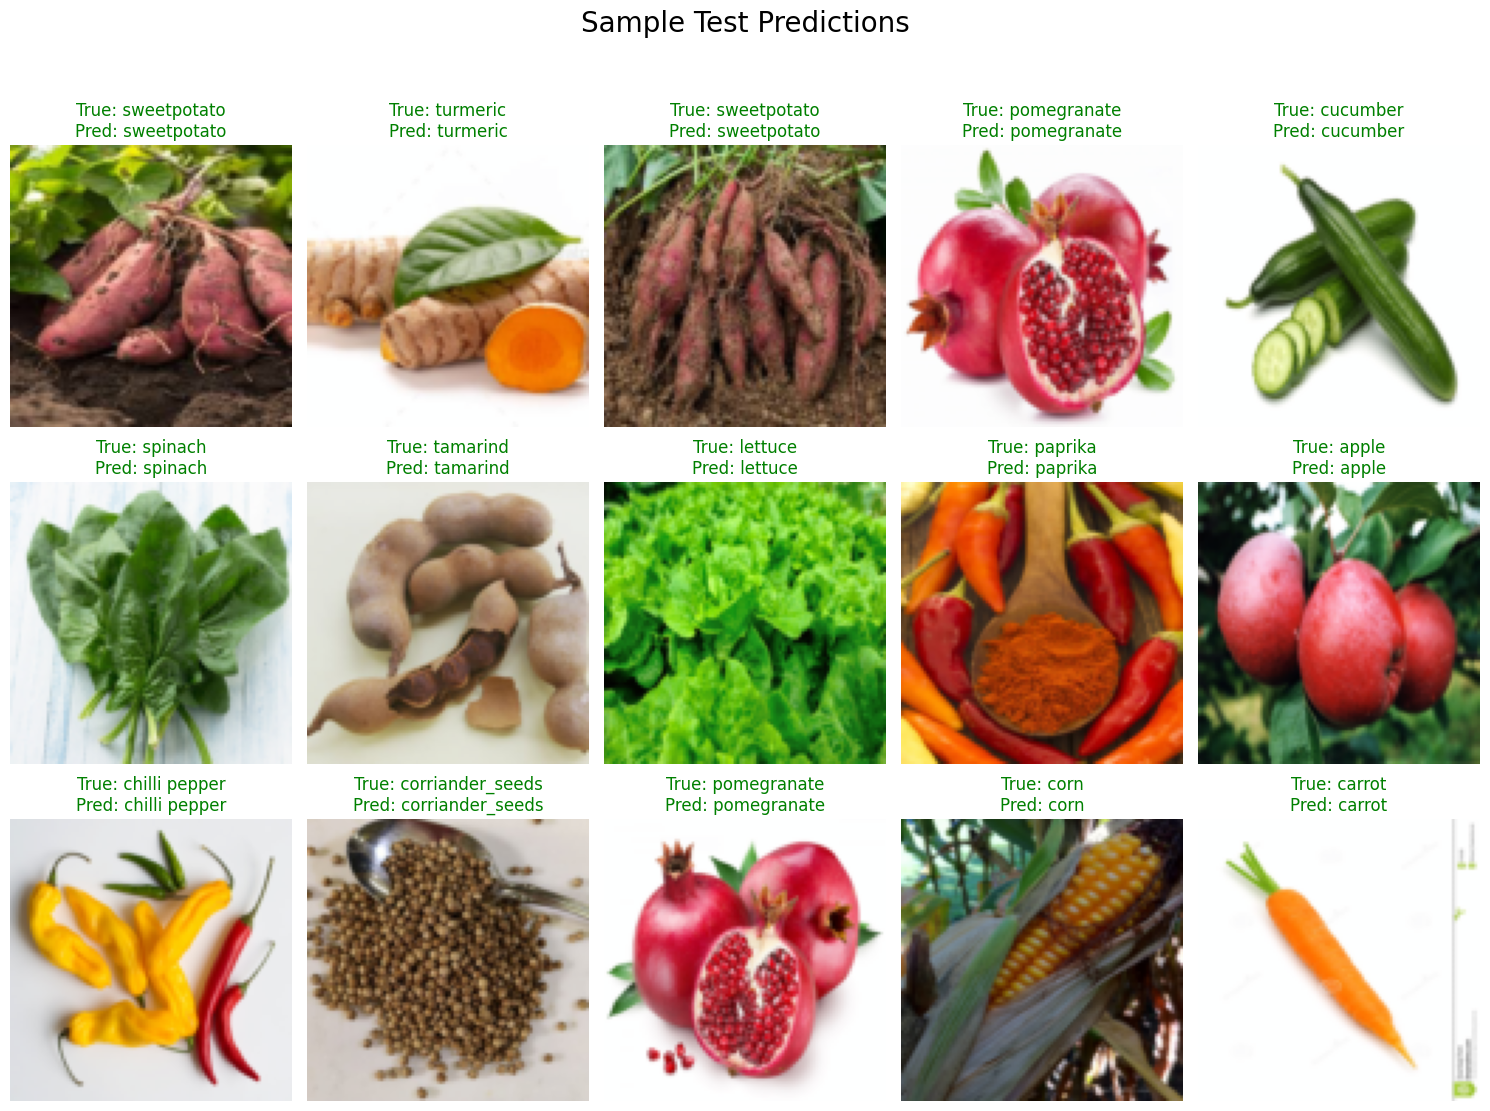

In [15]:
#Plotting training history
fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(12,10))
#Plot for Accuracy
ax[0].set_title('Training Accuracy vs Epochs')
ax[0].plot(history['train_acc'],'o-',label='Train Accuracy')
ax[0].plot(history['val_acc'],'o-',label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')
#Plot for Loss
ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(history['train_loss'],'o-',label='Train Loss')
ax[1].plot(history['val_loss'],'o-',label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')
plt.tight_layout()
plt.show()
#Generate f1 score
print("\nEvaluating on test data")
y_pred=[]
y_true=[]
model.eval()
with torch.no_grad():
    for inputs,labels in dataloaders['test']:
        inputs=inputs.to(device)
        labels=labels.to(device)
        outputs=model(inputs)
        _,predicted=torch.max(outputs,1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
print("\nClassification Report:\n")
print(classification_report(y_true,y_pred,target_names=class_names))
#Confusion matrix
print("\nGenerating Confusion Matrix...")
cf_mtx=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cf_mtx,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted Class',fontsize=12)
plt.ylabel('True Class',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()
#Individual class predictions
print("\nVisualizing a batch of test predictions")
#Batch of test data
inputs,labels=next(iter(dataloaders['test']))
inputs=inputs.to(device)
labels=labels.to(device)
#Get predictions
outputs=model(inputs)
_,preds=torch.max(outputs,1)
#Create a figure for the plot
fig=plt.figure(figsize=(15,12))
plt.suptitle('Sample Test Predictions',fontsize=20)
#Loop through a subset of the batch
for i in range(min(len(inputs),15)):
    ax=plt.subplot(3,5,i+1)
    #Un-normalize the image for display
    img=inputs[i].cpu().numpy().transpose((1,2,0))
    mean=np.array([0.485,0.456,0.406])
    std=np.array([0.229,0.224,0.225])
    img=std*img+mean
    img=np.clip(img,0,1)
    ax.imshow(img)
    true_label=class_names[labels[i]]
    pred_label=class_names[preds[i]]
    title_color="green" if preds[i] == labels[i] else "red"
    ax.set_title(f"True: {true_label}\nPred: {pred_label}",color=title_color)
    ax.axis('off')
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()